# Calibrating the Echoed CNOT gate

In [1]:
import logging
from copy import deepcopy
import numpy as np
from numpy import pi
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrieve_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    iterative_cr_pulse_calibration,
    create_echoed_cnot_schedule,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

/Users/bli/.local/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Setup a logging system.

In [2]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-04-25 12:08:46,744, MainThread 
INFO Logger initialized successfully.


Setup a simulator backend based on qiksit-dynamics and calibrate the single-qubit gates using the default calibrations from qiskit-experiment.

In [3]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1, J=0.003e9)

## Hamiltonian tomography
We define a Gaussian pulse shape, with a ramping time of 128 time unit, which is about 28.44 ns. Here we only use the default Gaussian pulse with no correction.

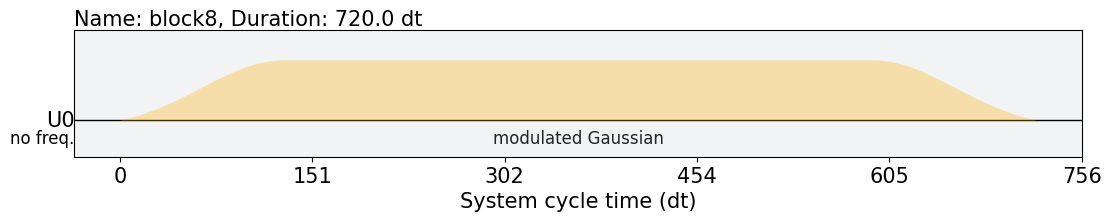

In [4]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Use the default Gaussian shape with 28ns ramping.
gate_name = "CR-default"  # This name will be used to identify the calibration
# CR drive
cr_params = {
    "duration": int(duration),  # only for plotting
    "sigma": 64,  # The ramping time is hard coded to be 2 * sigma
    "amp": amp,
    "angle": 0.,
}
# Target qubit compensation drive
ix_params = {
    "duration": int(duration),  # only for plotting
    "sigma": 64,
    "amp": 0.,
    "angle": 0.,
}
initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

We iteratively calibrate the CR and target qubit drive pulse such that only the ZY, IY and IX term are cancelled. In each calibration round, we perform two tomography experiment and use the data to compute the desired drive parameters. The detail is presented in the Supplemental material. The result will be saved a file "calibration_data.pickle".

2024-04-25 12:10:09,016, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-04-25 12:10:09,017, MainThread 
INFO 

CR calibration round 1: 
2024-04-25 12:10:09,112, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:12:07,399, MainThread 
INFO CR tomography: e9393376-148e-411d-82b3-2893438c4134
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 512
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': 0.0}
ix_params: {'duration': 720, 'sigma': 64, 'amp': 0.0, 'angle': 0.0}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e-10

2024-04-25 12:12:07,660, MainThread 
INFO Job saved to data/e9393376-148e-411d-82b3-2893438c4134



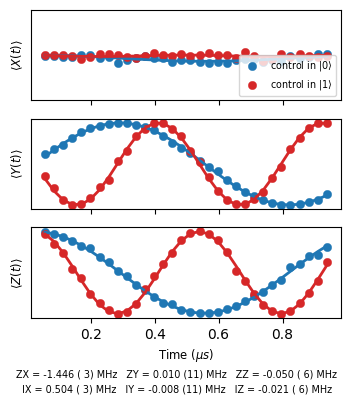

2024-04-25 12:12:08,316, MainThread 
INFO Tomography results:
{'IX': 0.5036467597992992, 'IY': -0.008076328809356109, 'IZ': -0.02054106202363471, 'ZX': -1.4456786699207143, 'ZY': 0.009592571478163114, 'ZZ': -0.04976828588841339}

2024-04-25 12:12:08,317, MainThread 
INFO Frequency offset is updated to -20541.06202363471 Hz
2024-04-25 12:12:08,318, MainThread 
INFO Remaining dominant error: IX: 0.5036467597992992 MHz

2024-04-25 12:12:08,318, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-04-25 12:12:08,319, MainThread 
INFO Probe amp shift [MHz]: -0.5036467597992992 MHz
2024-04-25 12:12:08,319, MainThread 
INFO Probe amp shift (amp): -0.003164505921179563
2024-04-25 12:12:08,416, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:13:44,617, MainThread 
INFO CR tomography: 5c33d8fb-1679-4bdf-a803-3b84dc50b464
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2

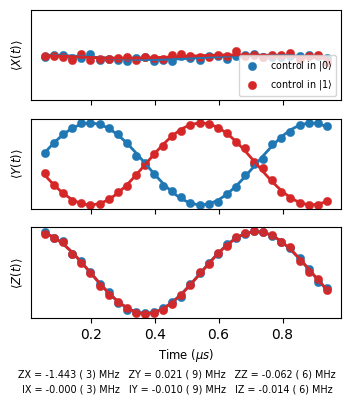

2024-04-25 12:13:45,526, MainThread 
INFO {'IX': -0.00046617955092227183, 'IY': -0.00997627501987362, 'IZ': -0.014486137261909112, 'ZX': -1.442692048326458, 'ZY': 0.021138238749097912, 'ZZ': -0.06199449562850726}
2024-04-25 12:13:45,527, MainThread 
INFO Estimated drive scale: 
(0.15930225820601862+0.0006003926862014877j)
(0.15930338960899315+0j)
0.0037688721441952173
2024-04-25 12:13:45,529, MainThread 
INFO CR calibration data saved.
2024-04-25 12:13:45,529, MainThread 
INFO 

CR calibration round 2: 
2024-04-25 12:13:45,633, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:15:21,729, MainThread 
INFO CR tomography: 6ff1e4dd-6a62-4878-9f04-eafac0de5491
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.006635

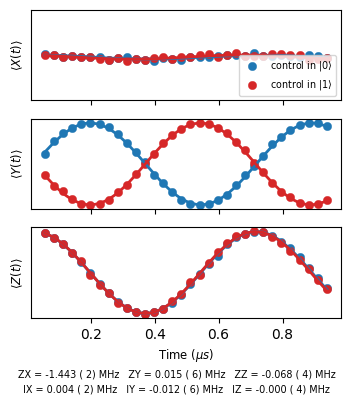

2024-04-25 12:15:22,787, MainThread 
INFO Tomography results:
{'IX': 0.0035567567500130078, 'IY': -0.01161985639056897, 'IZ': -0.0003057498360380627, 'ZX': -1.4428140841740904, 'ZY': 0.015401812721463785, 'ZZ': -0.06751668592627266}

2024-04-25 12:15:22,788, MainThread 
INFO Remaining dominant error: ZY: 0.015401812721463785 MHz

2024-04-25 12:15:22,789, MainThread 
INFO Omega[GHz]/amp: 0.15930338960899315
2024-04-25 12:15:22,789, MainThread 
INFO Probe amp shift [MHz]: 0.1 MHz
2024-04-25 12:15:22,789, MainThread 
INFO Probe amp shift (amp): -0.0006277330334617984
2024-04-25 12:15:22,917, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:16:56,390, MainThread 
INFO CR tomography: 096ae0b1-afa2-43c3-b0b9-6cc48e6afe09
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'duration': 72

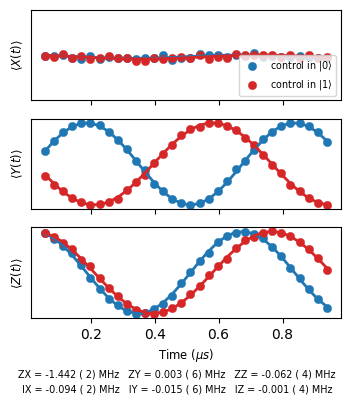

2024-04-25 12:16:57,256, MainThread 
INFO {'IX': -0.09361935724120322, 'IY': -0.015242192695508933, 'IZ': -0.0013211170860743893, 'ZX': -1.4420304656127843, 'ZY': 0.0034431749477078213, 'ZZ': -0.06193416489942756}
2024-04-25 12:16:57,257, MainThread 
INFO Estimated drive scale: 
(0.15480484347830645+0.0057705045168065135j)
(0.15491235679157894+0j)
0.037258744031006076
2024-04-25 12:16:57,259, MainThread 
INFO CR calibration data saved.
2024-04-25 12:16:57,259, MainThread 
INFO 

CR calibration round 3: 
2024-04-25 12:16:57,355, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:18:33,839, MainThread 
INFO CR tomography: 347d5f7a-1515-472e-9fa8-6bf7c207cd7e
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.017309

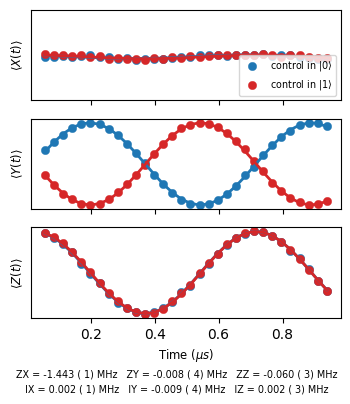

2024-04-25 12:18:34,730, MainThread 
INFO Tomography results:
{'IX': 0.0021619479634210226, 'IY': -0.008917052755618066, 'IZ': 0.0020635444597452662, 'ZX': -1.4425185940965939, 'ZY': -0.0076465583963200535, 'ZZ': -0.05964533410966963}

2024-04-25 12:18:34,731, MainThread 
INFO Remaining dominant error: IY: 0.008917052755618066 MHz

2024-04-25 12:18:34,731, MainThread 
INFO Successfully calibrated.
2024-04-25 12:18:34,733, MainThread 
INFO CR calibration data saved.


In [5]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    threshold_MHz=0.015,
    max_repeat=3,
    shots=512,
    mode="CR",
    )

## Calibration of the IY DRAG to suppress ZZ error
We Calibrate the IY-DRAG amplitude to suppress the ZZ error. We first perform three experiments with different beta parameters and then perform a linear fit.
- If the default Gaussian pulse is used, refer to the qiskit DRAG pulse for the definition of beta.
- If the custom DRAG pulse is used, `beta` refers to the constant scaling coefficient for the DRAG correction term.

2024-04-25 12:18:34,744, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-default.
2024-04-25 12:18:34,854, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:20:07,668, MainThread 
INFO CR tomography: 7b7ad0bc-cfd8-4016-b92c-a7c837673aec
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.01730968077478827}
ix_params: {'duration': 720, 'sigma': 64, 'amp': -0.003181493318569139, 'angle': 0.0, 'beta': 0.0}
x_gate_ix_params: None
frequency_offset: -20541.06202363471
dt: 2.2222222222222221e-10

2024-04-25 12:20:07,950, MainThread 
INFO Job saved to data/7b7ad0bc-cfd8-4016-b92c-a7c837673aec



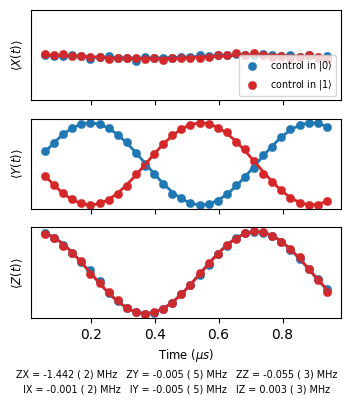

2024-04-25 12:20:08,706, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:21:43,352, MainThread 
INFO CR tomography: 97a820d6-dc24-440b-9973-9a41db6ec3b1
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.01730968077478827}
ix_params: {'duration': 720, 'sigma': 64, 'amp': -0.003181493318569139, 'angle': 0.0, 'beta': -100.0}
x_gate_ix_params: None
frequency_offset: -20541.06202363471
dt: 2.2222222222222221e-10

2024-04-25 12:21:43,629, MainThread 
INFO Job saved to data/97a820d6-dc24-440b-9973-9a41db6ec3b1



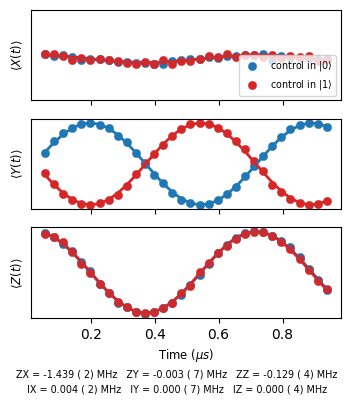

2024-04-25 12:21:44,396, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:23:21,316, MainThread 
INFO CR tomography: 016bc8d6-20a1-4ecc-bf27-375ec7336b27
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.01730968077478827}
ix_params: {'duration': 720, 'sigma': 64, 'amp': -0.003181493318569139, 'angle': 0.0, 'beta': 100.0}
x_gate_ix_params: None
frequency_offset: -20541.06202363471
dt: 2.2222222222222221e-10

2024-04-25 12:23:21,603, MainThread 
INFO Job saved to data/016bc8d6-20a1-4ecc-bf27-375ec7336b27



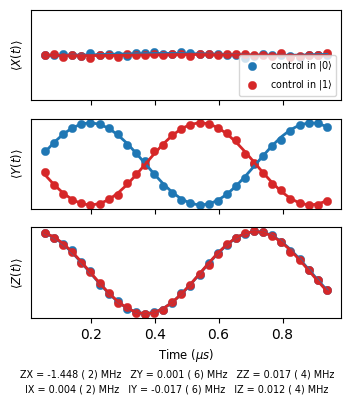

2024-04-25 12:23:22,170, MainThread 
INFO ZZ sampling measurements complete : [-0.055363575656798954, -0.12943679369764963, 0.016590943239569087].

2024-04-25 12:23:22,172, MainThread 
INFO Calibrated IY beta: 76.79336799979063



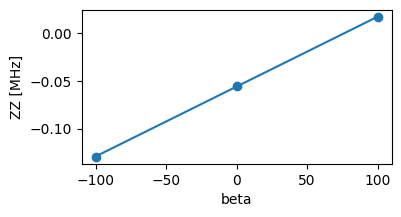

2024-04-25 12:23:22,420, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 12:24:57,742, MainThread 
INFO CR tomography: 62d5c489-4553-4f5a-a8ce-3ce88efdcebc
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'duration': 720, 'sigma': 64, 'amp': 0.25132741228718347, 'angle': -0.01730968077478827}
ix_params: {'duration': 720, 'sigma': 64, 'amp': -0.003181493318569139, 'angle': 0.0, 'beta': 76.79336799979063}
x_gate_ix_params: None
frequency_offset: -20541.06202363471
dt: 2.2222222222222221e-10

2024-04-25 12:24:58,046, MainThread 
INFO Job saved to data/62d5c489-4553-4f5a-a8ce-3ce88efdcebc



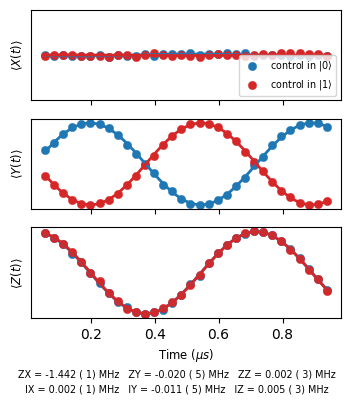

2024-04-25 12:24:58,601, MainThread 
INFO Updated coupling strength: {'IX': 0.0024985021731481864, 'IY': -0.010856580575835604, 'IZ': 0.005163923297921224, 'ZX': -1.4423051492022, 'ZY': -0.020043282959901845, 'ZZ': 0.0017700164900604513}
2024-04-25 12:24:58,603, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [6]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True)

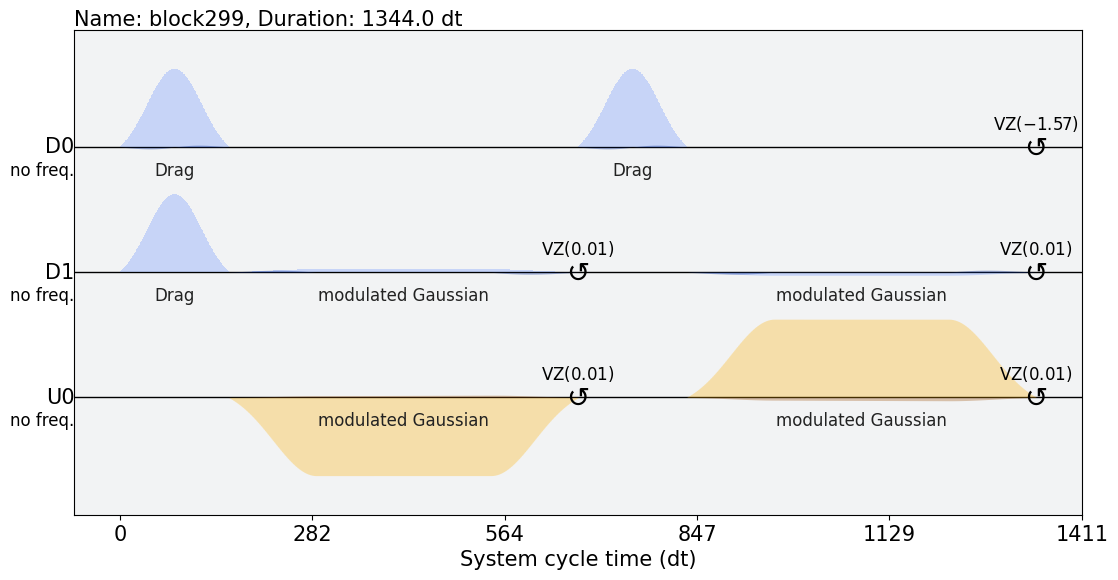

In [7]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, "CR-default", (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

In [8]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 4096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

2024-04-25 12:25:53,539, MainThread 
INFO Quantum process tomography job: 61814daa-55a1-4d98-ae0d-94a5a696faa0
backend: DynamicsBackend
qubits: (0, 1)
shots: 4096

2024-04-25 12:25:53,829, MainThread 
INFO Job saved to data/61814daa-55a1-4d98-ae0d-94a5a696faa0



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

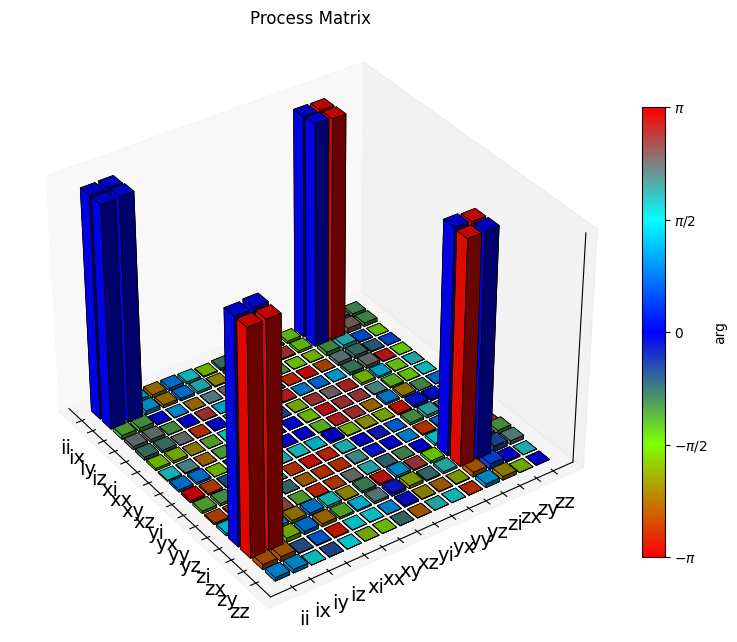

In [9]:
import qutip
from qutip.core.gates import cnot
qptdata = retrieve_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

Compare to the perfect CNOT gate:

(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

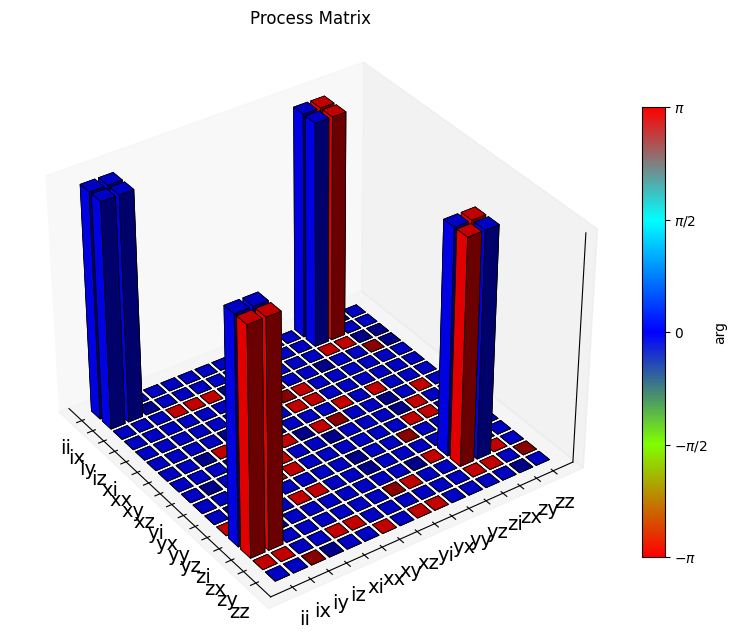

In [10]:
choi_qobj = qutip.to_choi(cnot())
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]]
lbls_list = [["i", "x", "y", "z"]]
if len(choi_qobj.dims[0][0]) == 2:
    op_basis = op_basis * 2
    lbls_list = lbls_list * 2
chi_qobj = qutip.qpt(qutip.to_super(choi_qobj), op_basis)

qutip.qpt_plot_combined(chi_qobj, lbls_list=lbls_list, title="Process Matrix")